In [1]:
# Install pyspark

!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u402-ga-2ubuntu1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [2]:
# Import libraries

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
import tqdm
import psutil
import time
import math

from google.colab import drive

In [3]:
# Create spark session
spark = SparkSession.builder.getOrCreate()

# Create spark context
sc = spark.sparkContext

# Check how much memory is allocated to spark runtime
mem_info = psutil.virtual_memory()
total_memory_gb = mem_info.total / (1024 * 1024 * 1024)
print("Total Memory Allocated to Spark Runtime:", int(total_memory_gb), "GB")

Total Memory Allocated to Spark Runtime: 334 GB


In [4]:
# Mount google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
##
# Load data
#

folder = '/content/drive/MyDrive/Colab Notebooks/cse 547 - hw 4/streams data/'

name = 'counts.txt'
path = folder + name
counts = np.loadtxt(path, delimiter = '\t', dtype = int)

name = 'counts_tiny.txt'
path = folder + name
counts_tiny = np.loadtxt(path, delimiter = '\t', dtype = int)

name = 'words_stream.txt'
path = folder + name
words_stream = np.loadtxt(path, delimiter = ',', dtype = int)

name = 'words_stream_tiny.txt'
path = folder + name
words_stream_tiny = np.loadtxt(path, delimiter = ',', dtype = int)

name = 'hash_params.txt'
path = folder + name
hash_params = np.loadtxt(path, delimiter = '\t', dtype = int)

In [6]:
##
# Choose tiny or large data-set
#

data = words_stream
freq = counts


# Inspect data

print(data[:23])
print(freq[:10])
print(hash_params)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 13 16 17  6 18 19 20 21]
[[      1  831376]
 [      2  144043]
 [      3 4872808]
 [      4   32432]
 [      5   59310]
 [      6 8609958]
 [      7    7037]
 [      8   53693]
 [      9 6737582]
 [     10  265392]]
[[   3 1561]
 [  17  277]
 [  38  394]
 [  61   13]
 [  78  246]]


In [7]:
##
# Set global parameters
#

# Algorithm parameters
delta = np.exp(-5)
eps = np.exp(1) * 10**(-4)
n_hash_funs = math.ceil(np.log(1 / delta))
n_buckets = math.ceil(np.exp(1) / eps)


# Data parameters
t = data.shape[0] # total length of stream
l = freq.shape[0] # number of distinct elements in stream


# Hash function parameters
a = hash_params[:, 0]
b = hash_params[:, 1]
p = 123457 # for hash function

In [8]:
##
# Read in true counts
#

F = np.zeros(l)

for i in tqdm.trange(l):

    F[i] = freq[i, 1]



# Form array of exact word frequencies

EWF = F / t

100%|██████████| 1407593/1407593 [00:00<00:00, 1559510.43it/s]


In [9]:
##
# Returns hash(x) for hash function given by parameters a, b, p and n_buckets
#

def hash_fun(a, b, p, n_buckets, x):

    y = x % p

    hash_val = (a * y + b) % p

    return hash_val % n_buckets

In [10]:
##
# Make one pass over the entire data stream to compute bucket counts
#

c = np.zeros((n_hash_funs, n_buckets)) # array of counters

for i in tqdm.trange(t):

    x = data[i] # read the data stream

    for j in range(n_hash_funs):

        bucket = hash_fun(a[j], b[j], p, n_buckets, x) # hash to a bucket
        c[j, bucket] += 1 # increment the counter

100%|██████████| 196432300/196432300 [19:47<00:00, 165422.76it/s]


In [11]:
##
# Iterate over each distinct item to find its minimum bucket count across
# all hash functions

tilde_F = np.zeros(l) # will hold approximate item counts
Er = np.zeros(l) # will hold relative errors


for i in tqdm.trange(l):

    x = freq[i, 0] # read a distinct element
    counts = np.zeros(n_hash_funs)

    for j in range(n_hash_funs):

        bucket = hash_fun(a[j], b[j], p, n_buckets, x) # re-hash x to its buckets
        counts[j] = c[j, bucket] # retrieve the count from each bucket

    tilde_F[i] = np.min(counts) # find the minimum count across x's buckets
    Er[i] = (tilde_F[i] - F[i]) / F[i] # calculate relative error

100%|██████████| 1407593/1407593 [00:14<00:00, 94899.61it/s]


In [12]:
##
# Check results (for TINY dataset)
#

# Check 1
print(f"On the TINY dataset, exact word frequencies range from around {1e-7} to {0.05}")
print(f"Our results show from {np.min(EWF):2e} to {np.round(np.max(EWF), 5)}")

print(f"\nLikewise, relative errors range from around {1e-4:.2e} to {3e5:.2e}")
print(f"Our results show from {np.min(Er):.2e} to {np.max(Er):.2e}")

# Check 2
idx = (EWF < 10**(-3)) & (EWF > 10**(-4))
idx2 = Er[idx] < 10**(-1)
print(f"\nFinally, almost all words with frequency between {1e-3:.2e} and {1e-4:.2e}")
print(f"have relative errors below {1e-1:.2e}. Our results show {np.round(100 * (Er[idx][idx2].shape[0] / Er[idx].shape[0]), 3)}%")

On the TINY dataset, exact word frequencies range from around 1e-07 to 0.05
Our results show from 5.090812e-09 to 0.04383

Likewise, relative errors range from around 1.00e-04 to 3.00e+05
Our results show from 1.39e-04 to 8.61e+06

Finally, almost all words with frequency between 1.00e-03 and 1.00e-04
have relative errors below 1.00e-01. Our results show 100.0%


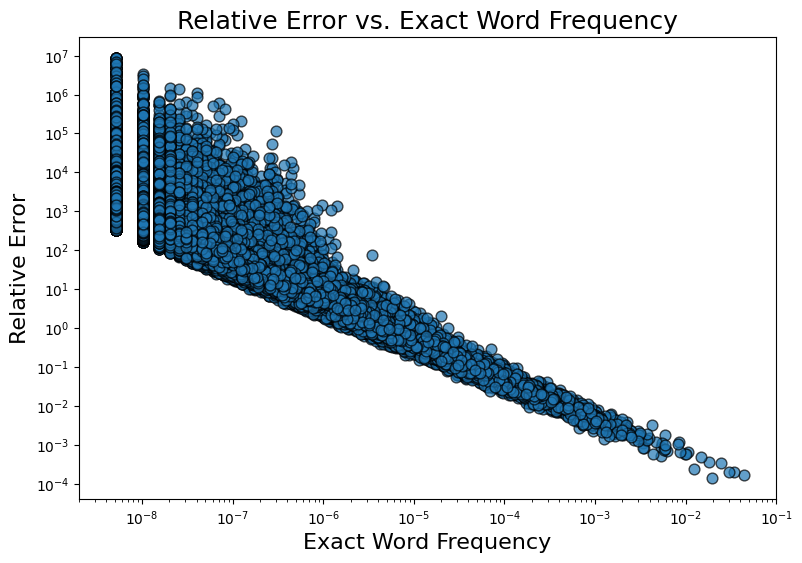

In [19]:
##
# Plot relative error as a function of exact word frequency
#

x = EWF # exact word frequency
y = Er # relative error

# Create scatter plot
fig, ax = plt.subplots(figsize = (9, 6))
ax.scatter(x, y, s = 60, alpha = 0.7, edgecolors = "k")

# Add a horizontal line at y = 1
# ax.axhline(y = 1, color = 'g', linestyle = ':')

# Set logarithmic scale on both variables
ax.set_xscale("log")
ax.set_yscale("log")

# Set plot title and axis labels
ax.set_title("Relative Error vs. Exact Word Frequency", fontsize = 18)
ax.set_xlabel("Exact Word Frequency", fontsize = 16)
ax.set_ylabel("Relative Error", fontsize = 16)

# Ensure every power of ten is displayed on both axes
from matplotlib.ticker import LogLocator
ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=20))

# Create a custom zoom if desired
ax.set_xlim([2e-9, 1e-1]);